This model is an image classification model. It quickly classifies if the image contains a boat or not. This model will be in the input for the final model. Only images containing a boat will be feeded to the instance segementation model. 

## Model Parameters

In [1]:
VALID_IMG_COUNT = 500
MAX_TRAIN_IMAGES = 30000
IMG_SIZE = (512, 512) 
BATCH_SIZE = 2 
LEARN_RATE = 1e-3


In [2]:
import os
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.util.montage import montage2d as montage
import gc
%matplotlib inline

montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ship_dir = 'input'
train_image_dir = os.path.join(ship_dir, 'train')
test_image_dir = os.path.join(ship_dir, 'test')

gc.enable() 


In [3]:
masks = pd.read_csv(os.path.join(ship_dir,
                                 'train_ship_segmentations.csv'))
print(masks.shape[0], 'masks found')
print('Number of unique images: {}'.format(masks['ImageId'].value_counts().shape[0]))
masks['path'] = masks['ImageId'].map(lambda x: os.path.join(train_image_dir, x))
masks.head()

131030 masks found
Number of unique images: 104070


,ImageId,EncodedPixels,path
0,00003e153.jpg,NaN,input/train/00003e153.jpg
1,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,input/train/000155de5.jpg
2,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...,input/train/00021ddc3.jpg
3,00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...,input/train/00021ddc3.jpg
4,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...,input/train/00021ddc3.jpg


# Split into training and validation groups
We stratify by the number of boats appearing so we have nice balances in each set

In [4]:
from sklearn.model_selection import train_test_split

masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x > 0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
masks.drop(['ships'], axis=1, inplace=True)
train_ids, valid_ids = train_test_split(unique_img_ids,
                                        test_size=0.3,
                                        stratify=unique_img_ids['ships'])
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')


91709 training masks
39321 validation masks


In [5]:
train_df = train_df.sample(min(MAX_TRAIN_IMAGES, train_df.shape[0])) # limit size of training set (otherwise it takes too long)
train_df.head()

,ImageId,EncodedPixels,path,ships,has_ship,has_ship_vec
55405,9a871e01d.jpg,NaN,input/train/9a871e01d.jpg,0,0.0,[0.0]
51605,8fd50113b.jpg,NaN,input/train/8fd50113b.jpg,0,0.0,[0.0]
45760,7efa6b7af.jpg,NaN,input/train/7efa6b7af.jpg,0,0.0,[0.0]
41339,73139dfe3.jpg,NaN,input/train/73139dfe3.jpg,0,0.0,[0.0]
32414,5abc7696b.jpg,NaN,input/train/5abc7696b.jpg,0,0.0,[0.0]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10ad1c2e8>,
      dtype=object)

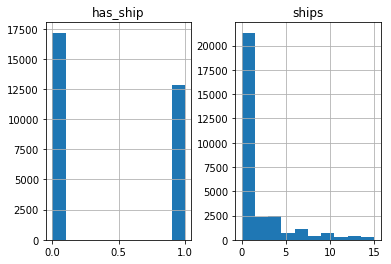

In [6]:
train_df[['ships', 'has_ship']].hist()

# Augment Data

In [8]:
from keras.preprocessing.image import ImageDataGenerator

dg_args = dict(featurewise_center=False,
               samplewise_center=False,
               rotation_range=45,
               width_shift_range=0.1,
               height_shift_range=0.1,
               shear_range=0.01,
               zoom_range=[0.9, 1.25],
               brightness_range=[0.5, 1.5],
               horizontal_flip=True,
               vertical_flip=True,
               fill_mode='reflect',
               data_format='channels_last')
valid_args = dict(fill_mode='reflect',
                  data_format='channels_last')

train_idg = ImageDataGenerator(**dg_args)
valid_idg = ImageDataGenerator(**valid_args)


In [9]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir,
                                              class_mode='sparse',
                                              **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = ''  # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen


In [11]:
train_gen = flow_from_dataframe(train_idg, train_df,
                                path_col='path',
                                y_col='has_ship_vec',
                                target_size=IMG_SIZE,
                                color_mode='rgb',
                                batch_size=BATCH_SIZE)

# used a fixed dataset for evaluating the algorithm
valid_x, valid_y = next(flow_from_dataframe(valid_idg,
                                            valid_df,
                                            path_col='path',
                                            y_col='has_ship_vec',
                                            target_size=IMG_SIZE,
                                            color_mode='rgb',
                                            batch_size=VALID_IMG_COUNT))  # one big batch
print(valid_x.shape, valid_y.shape)


## Ignore next message from keras, values are replaced anyways


Found 0 images belonging to 0 classes.


Reinserting dataframe: 30000 images
## Ignore next message from keras, values are replaced anyways


Found 0 images belonging to 0 classes.


Reinserting dataframe: 39321 images


(500, 512, 512, 3) (500, 1)


In [21]:
t_x, t_y = next(train_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())


x (2, 512, 512, 3) float32 0.0 255.0
y (2, 1) float64 0.0 0.0


# Build a Model


In [30]:
from keras import models, layers
from keras.optimizers import Adam
import keras.backend as K

img_in = layers.Input(shape=t_x.shape[1:], name="RGB_Input")
norm = layers.Lambda(lambda img: img - K.mean(img))(img_in)

c1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(norm)
c2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(c1)
p1 = layers.MaxPooling2D((2, 2), strides=(2, 2))(c2)

c3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(p1)
c4 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(c3)
p2 = layers.MaxPooling2D((2, 2), strides=(2, 2))(c4)

c5 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(p2)
c6 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(c5)
p3 = layers.MaxPooling2D((2, 2), strides=(2, 2))(c6)

p5 = layers.GlobalMaxPooling2D()(p3)
dense1 = layers.Dense(128, activation='relu')(p5)
drop = layers.Dropout(0.5)(dense1)
out_layer = layers.Dense(1, activation='sigmoid')(drop)

ship_model = models.Model(inputs=[img_in], outputs=[out_layer], name='full_model')

ship_model.compile(optimizer=Adam(lr=LEARN_RATE),
                   loss='binary_crossentropy',
                   metrics=['binary_accuracy'])

ship_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RGB_Input (InputLayer)       (None, 512, 512, 3)       0         
_________________________________________________________________
lambda_12 (Lambda)           (None, 512, 512, 3)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 512, 512, 16)      448       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 512, 512, 32)      4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 256, 256, 32)      9248      
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 256, 256, 32)      9248      
__________

In [31]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

weight_path = "{}_weights_classification.best.hdf5".format('boat')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001,
                                   cooldown=5, min_lr=0.0001)

early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=15)

callbacks_list = [checkpoint, early, reduceLROnPlat]


/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:999: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


# Train model

In [33]:

ship_model.fit_generator(train_gen,
                         validation_data=(valid_x, valid_y),
                         epochs=10,
                         steps_per_epoch=100,
                         callbacks=callbacks_list,
                         workers=1)


Epoch 1/10


  1/100 [..............................] - ETA: 3:14 - loss: 0.4446 - binary_accuracy: 1.0000

  2/100 [..............................] - ETA: 2:54 - loss: 0.6116 - binary_accuracy: 0.7500

  3/100 [..............................] - ETA: 2:38 - loss: 1.3099 - binary_accuracy: 0.5000

  4/100 [>.............................] - ETA: 2:27 - loss: 0.9947 - binary_accuracy: 0.6250

  5/100 [>.............................] - ETA: 2:21 - loss: 0.8483 - binary_accuracy: 0.7000

  6/100 [>.............................] - ETA: 2:16 - loss: 1.3901 - binary_accuracy: 0.5833

  7/100 [=>............................] - ETA: 2:11 - loss: 1.1947 - binary_accuracy: 0.6429

  8/100 [=>............................] - ETA: 2:08 - loss: 1.0929 - binary_accuracy: 0.6250

  9/100 [=>............................] - ETA: 2:04 - loss: 1.0296 - binary_accuracy: 0.6111

 10/100 [==>...........................] - ETA: 2:02 - loss: 1.0458 - binary_accuracy: 0.6000

 11/100 [==>...........................] - ETA: 1:59 - loss: 1.0155 - binary_accuracy: 0.5909

 12/100 [==>...........................] - ETA: 1:57 - loss: 1.0457 - binary_accuracy: 0.5833

 13/100 [==>...........................] - ETA: 1:55 - loss: 1.0956 - binary_accuracy: 0.5769

 14/100 [===>..........................] - ETA: 1:52 - loss: 1.2144 - binary_accuracy: 0.5357

 15/100 [===>..........................] - ETA: 1:51 - loss: 1.1350 - binary_accuracy: 0.5667

 16/100 [===>..........................] - ETA: 1:49 - loss: 1.0894 - binary_accuracy: 0.5938

 17/100 [====>.........................] - ETA: 1:47 - loss: 1.2868 - binary_accuracy: 0.5588

 18/100 [====>.........................] - ETA: 1:45 - loss: 1.3457 - binary_accuracy: 0.5278

 19/100 [====>.........................] - ETA: 1:44 - loss: 1.3212 - binary_accuracy: 0.5000

 20/100 [=====>........................] - ETA: 1:42 - loss: 1.3196 - binary_accuracy: 0.5000

 21/100 [=====>........................] - ETA: 1:40 - loss: 1.2635 - binary_accuracy: 0.5238

 22/100 [=====>........................] - ETA: 1:39 - loss: 1.2166 - binary_accuracy: 0.5455

 23/100 [=====>........................] - ETA: 1:37 - loss: 1.1725 - binary_accuracy: 0.5652

 24/100 [======>.......................] - ETA: 1:36 - loss: 1.1628 - binary_accuracy: 0.5625

 25/100 [======>.......................] - ETA: 1:34 - loss: 1.1808 - binary_accuracy: 0.5600

 26/100 [======>.......................] - ETA: 1:33 - loss: 1.1450 - binary_accuracy: 0.5769

 27/100 [=======>......................] - ETA: 1:32 - loss: 1.1417 - binary_accuracy: 0.5556

 28/100 [=======>......................] - ETA: 1:30 - loss: 1.1079 - binary_accuracy: 0.5714

 29/100 [=======>......................] - ETA: 1:29 - loss: 1.0760 - binary_accuracy: 0.5862

 30/100 [========>.....................] - ETA: 1:27 - loss: 1.0589 - binary_accuracy: 0.5833

 31/100 [========>.....................] - ETA: 1:26 - loss: 1.0903 - binary_accuracy: 0.5645

 32/100 [========>.....................] - ETA: 1:25 - loss: 1.0677 - binary_accuracy: 0.5781

 33/100 [========>.....................] - ETA: 1:23 - loss: 1.0480 - binary_accuracy: 0.5909

 34/100 [=========>....................] - ETA: 1:22 - loss: 1.0315 - binary_accuracy: 0.5882

 35/100 [=========>....................] - ETA: 1:21 - loss: 1.0188 - binary_accuracy: 0.5857

 36/100 [=========>....................] - ETA: 1:19 - loss: 1.0117 - binary_accuracy: 0.5833

 37/100 [==========>...................] - ETA: 1:18 - loss: 1.0084 - binary_accuracy: 0.5676

 38/100 [==========>...................] - ETA: 1:17 - loss: 1.0274 - binary_accuracy: 0.5526

 39/100 [==========>...................] - ETA: 1:15 - loss: 1.0159 - binary_accuracy: 0.5513

 40/100 [===========>..................] - ETA: 1:14 - loss: 0.9999 - binary_accuracy: 0.5625

 41/100 [===========>..................] - ETA: 1:13 - loss: 0.9997 - binary_accuracy: 0.5488

 42/100 [===========>..................] - ETA: 1:12 - loss: 1.0105 - binary_accuracy: 0.5357

 43/100 [===========>..................] - ETA: 1:10 - loss: 1.0045 - binary_accuracy: 0.5349

 44/100 [============>.................] - ETA: 1:09 - loss: 0.9983 - binary_accuracy: 0.5341

 45/100 [============>.................] - ETA: 1:08 - loss: 0.9907 - binary_accuracy: 0.5333

 46/100 [============>.................] - ETA: 1:06 - loss: 0.9790 - binary_accuracy: 0.5326

 47/100 [=============>................] - ETA: 1:05 - loss: 0.9654 - binary_accuracy: 0.5426

 48/100 [=============>................] - ETA: 1:04 - loss: 0.9597 - binary_accuracy: 0.5417

 49/100 [=============>................] - ETA: 1:03 - loss: 0.9553 - binary_accuracy: 0.5306

 50/100 [==============>...............] - ETA: 1:01 - loss: 0.9451 - binary_accuracy: 0.5300

 51/100 [==============>...............] - ETA: 1:00 - loss: 0.9387 - binary_accuracy: 0.5294

 52/100 [==============>...............] - ETA: 59s - loss: 0.9284 - binary_accuracy: 0.5385 

 53/100 [==============>...............] - ETA: 58s - loss: 0.9132 - binary_accuracy: 0.5472

 54/100 [===============>..............] - ETA: 56s - loss: 0.9184 - binary_accuracy: 0.5463

 55/100 [===============>..............] - ETA: 55s - loss: 0.9187 - binary_accuracy: 0.5364

 56/100 [===============>..............] - ETA: 54s - loss: 0.9286 - binary_accuracy: 0.5357

 57/100 [================>.............] - ETA: 53s - loss: 0.9206 - binary_accuracy: 0.5439

 58/100 [================>.............] - ETA: 51s - loss: 0.9179 - binary_accuracy: 0.5431

 59/100 [================>.............] - ETA: 50s - loss: 0.9096 - binary_accuracy: 0.5424

 60/100 [=================>............] - ETA: 49s - loss: 0.9022 - binary_accuracy: 0.5500

 61/100 [=================>............] - ETA: 48s - loss: 0.8905 - binary_accuracy: 0.5574

 62/100 [=================>............] - ETA: 46s - loss: 0.8889 - binary_accuracy: 0.5484

 63/100 [=================>............] - ETA: 45s - loss: 0.8756 - binary_accuracy: 0.5556

 64/100 [==================>...........] - ETA: 44s - loss: 0.8630 - binary_accuracy: 0.5625

 65/100 [==================>...........] - ETA: 43s - loss: 0.8576 - binary_accuracy: 0.5692

 66/100 [==================>...........] - ETA: 41s - loss: 0.8734 - binary_accuracy: 0.5606

 67/100 [===================>..........] - ETA: 40s - loss: 0.8691 - binary_accuracy: 0.5597

 68/100 [===================>..........] - ETA: 39s - loss: 0.8593 - binary_accuracy: 0.5662

 69/100 [===================>..........] - ETA: 38s - loss: 0.8489 - binary_accuracy: 0.5725

 70/100 [====================>.........] - ETA: 36s - loss: 0.8450 - binary_accuracy: 0.5714

 71/100 [====================>.........] - ETA: 35s - loss: 0.8379 - binary_accuracy: 0.5775

 72/100 [====================>.........] - ETA: 34s - loss: 0.8315 - binary_accuracy: 0.5833

 73/100 [====================>.........] - ETA: 33s - loss: 0.8384 - binary_accuracy: 0.5822

 74/100 [=====================>........] - ETA: 32s - loss: 0.8323 - binary_accuracy: 0.5878

 75/100 [=====================>........] - ETA: 31s - loss: 0.8234 - binary_accuracy: 0.5933

 76/100 [=====================>........] - ETA: 29s - loss: 0.8146 - binary_accuracy: 0.5987

 77/100 [======================>.......] - ETA: 28s - loss: 0.8388 - binary_accuracy: 0.5909

 78/100 [======================>.......] - ETA: 27s - loss: 0.8368 - binary_accuracy: 0.5897

 79/100 [======================>.......] - ETA: 26s - loss: 0.8288 - binary_accuracy: 0.5949

 80/100 [=======================>......] - ETA: 24s - loss: 0.8196 - binary_accuracy: 0.6000

 81/100 [=======================>......] - ETA: 23s - loss: 0.8111 - binary_accuracy: 0.6049

 82/100 [=======================>......] - ETA: 22s - loss: 0.8128 - binary_accuracy: 0.6037

 83/100 [=======================>......] - ETA: 21s - loss: 0.8154 - binary_accuracy: 0.6024

 84/100 [========================>.....] - ETA: 19s - loss: 0.8125 - binary_accuracy: 0.6012

 85/100 [========================>.....] - ETA: 18s - loss: 0.8067 - binary_accuracy: 0.6059

 86/100 [========================>.....] - ETA: 17s - loss: 0.8046 - binary_accuracy: 0.6047

 87/100 [=========================>....] - ETA: 16s - loss: 0.8074 - binary_accuracy: 0.5977

 88/100 [=========================>....] - ETA: 14s - loss: 0.8095 - binary_accuracy: 0.5909

 89/100 [=========================>....] - ETA: 13s - loss: 0.8035 - binary_accuracy: 0.5955

 90/100 [==========================>...] - ETA: 12s - loss: 0.8074 - binary_accuracy: 0.5889

 91/100 [==========================>...] - ETA: 11s - loss: 0.8077 - binary_accuracy: 0.5879

 92/100 [==========================>...] - ETA: 10s - loss: 0.8259 - binary_accuracy: 0.5870

 93/100 [==========================>...] - ETA: 8s - loss: 0.8396 - binary_accuracy: 0.5806 

 94/100 [===========================>..] - ETA: 7s - loss: 0.8343 - binary_accuracy: 0.5851

 95/100 [===========================>..] - ETA: 6s - loss: 0.8320 - binary_accuracy: 0.5842

 96/100 [===========================>..] - ETA: 5s - loss: 0.8286 - binary_accuracy: 0.5885

 97/100 [============================>.] - ETA: 3s - loss: 0.8269 - binary_accuracy: 0.5876

 98/100 [============================>.] - ETA: 2s - loss: 0.8206 - binary_accuracy: 0.5918

 99/100 [============================>.] - ETA: 1s - loss: 0.8215 - binary_accuracy: 0.5859

100/100 [==============================] - 245s 2s/step - loss: 0.8206 - binary_accuracy: 0.5850 - val_loss: 0.6755 - val_binary_accuracy: 0.5920



Epoch 00001: val_loss improved from inf to 0.67550, saving model to boat_weights_classification.best.hdf5


Epoch 2/10


  1/100 [..............................] - ETA: 2:28 - loss: 1.2444 - binary_accuracy: 0.0000e+00

  2/100 [..............................] - ETA: 2:25 - loss: 0.8582 - binary_accuracy: 0.5000    

  3/100 [..............................] - ETA: 2:26 - loss: 0.8192 - binary_accuracy: 0.5000

  4/100 [>.............................] - ETA: 2:27 - loss: 0.7830 - binary_accuracy: 0.5000

  5/100 [>.............................] - ETA: 2:24 - loss: 0.6777 - binary_accuracy: 0.6000

  6/100 [>.............................] - ETA: 2:21 - loss: 0.6824 - binary_accuracy: 0.5833

  7/100 [=>............................] - ETA: 2:17 - loss: 0.6373 - binary_accuracy: 0.6429

  8/100 [=>............................] - ETA: 2:14 - loss: 0.6519 - binary_accuracy: 0.5625

  9/100 [=>............................] - ETA: 2:11 - loss: 0.6352 - binary_accuracy: 0.5556

 10/100 [==>...........................] - ETA: 2:08 - loss: 0.6373 - binary_accuracy: 0.5500

 11/100 [==>...........................] - ETA: 2:05 - loss: 0.6450 - binary_accuracy: 0.5455

 12/100 [==>...........................] - ETA: 2:02 - loss: 0.6509 - binary_accuracy: 0.5417

 13/100 [==>...........................] - ETA: 2:00 - loss: 0.6610 - binary_accuracy: 0.5000

 14/100 [===>..........................] - ETA: 1:59 - loss: 0.6584 - binary_accuracy: 0.5357

 15/100 [===>..........................] - ETA: 1:59 - loss: 0.6688 - binary_accuracy: 0.5000

 16/100 [===>..........................] - ETA: 1:58 - loss: 0.7013 - binary_accuracy: 0.5000

 17/100 [====>.........................] - ETA: 1:58 - loss: 0.6906 - binary_accuracy: 0.5294

 18/100 [====>.........................] - ETA: 1:57 - loss: 0.6913 - binary_accuracy: 0.5278

 19/100 [====>.........................] - ETA: 1:55 - loss: 0.6990 - binary_accuracy: 0.5000

 20/100 [=====>........................] - ETA: 1:53 - loss: 0.6763 - binary_accuracy: 0.5250

 21/100 [=====>........................] - ETA: 1:51 - loss: 0.6648 - binary_accuracy: 0.5476

 22/100 [=====>........................] - ETA: 1:49 - loss: 0.6629 - binary_accuracy: 0.5682

 23/100 [=====>........................] - ETA: 1:48 - loss: 0.6576 - binary_accuracy: 0.5652

 24/100 [======>.......................] - ETA: 1:47 - loss: 0.6639 - binary_accuracy: 0.5625

 25/100 [======>.......................] - ETA: 1:47 - loss: 0.6691 - binary_accuracy: 0.5600

 26/100 [======>.......................] - ETA: 1:45 - loss: 0.6716 - binary_accuracy: 0.5577

 27/100 [=======>......................] - ETA: 1:43 - loss: 0.6711 - binary_accuracy: 0.5556

 28/100 [=======>......................] - ETA: 1:41 - loss: 0.6826 - binary_accuracy: 0.5536

 29/100 [=======>......................] - ETA: 1:40 - loss: 0.6843 - binary_accuracy: 0.5517

 30/100 [========>.....................] - ETA: 1:39 - loss: 0.6837 - binary_accuracy: 0.5500

 31/100 [========>.....................] - ETA: 1:37 - loss: 0.6915 - binary_accuracy: 0.5484

 32/100 [========>.....................] - ETA: 1:36 - loss: 0.6787 - binary_accuracy: 0.5625

 33/100 [========>.....................] - ETA: 1:35 - loss: 0.6925 - binary_accuracy: 0.5606

 34/100 [=========>....................] - ETA: 1:33 - loss: 0.6866 - binary_accuracy: 0.5735

 35/100 [=========>....................] - ETA: 1:32 - loss: 0.6766 - binary_accuracy: 0.5857

 36/100 [=========>....................] - ETA: 1:31 - loss: 0.6837 - binary_accuracy: 0.5833

 37/100 [==========>...................] - ETA: 1:30 - loss: 0.6737 - binary_accuracy: 0.5946

 38/100 [==========>...................] - ETA: 1:28 - loss: 0.6676 - binary_accuracy: 0.6053

 39/100 [==========>...................] - ETA: 1:27 - loss: 0.6643 - binary_accuracy: 0.6154

 40/100 [===========>..................] - ETA: 1:26 - loss: 0.6634 - binary_accuracy: 0.6125

 41/100 [===========>..................] - ETA: 1:24 - loss: 0.6535 - binary_accuracy: 0.6220

 42/100 [===========>..................] - ETA: 1:23 - loss: 0.6459 - binary_accuracy: 0.6310

 43/100 [===========>..................] - ETA: 1:21 - loss: 0.6429 - binary_accuracy: 0.6279

 44/100 [============>.................] - ETA: 1:20 - loss: 0.6361 - binary_accuracy: 0.6364

 45/100 [============>.................] - ETA: 1:18 - loss: 0.6401 - binary_accuracy: 0.6222

 46/100 [============>.................] - ETA: 1:17 - loss: 0.6338 - binary_accuracy: 0.6304

 47/100 [=============>................] - ETA: 1:16 - loss: 0.6308 - binary_accuracy: 0.6277

 48/100 [=============>................] - ETA: 1:14 - loss: 0.6239 - binary_accuracy: 0.6354

 49/100 [=============>................] - ETA: 1:13 - loss: 0.6191 - binary_accuracy: 0.6429

 50/100 [==============>...............] - ETA: 1:11 - loss: 0.6206 - binary_accuracy: 0.6400

 51/100 [==============>...............] - ETA: 1:10 - loss: 0.6097 - binary_accuracy: 0.6471

 52/100 [==============>...............] - ETA: 1:09 - loss: 0.6055 - binary_accuracy: 0.6442

 53/100 [==============>...............] - ETA: 1:07 - loss: 0.5981 - binary_accuracy: 0.6509

 54/100 [===============>..............] - ETA: 1:06 - loss: 0.5914 - binary_accuracy: 0.6574

 55/100 [===============>..............] - ETA: 1:04 - loss: 0.5912 - binary_accuracy: 0.6545

 56/100 [===============>..............] - ETA: 1:03 - loss: 0.5851 - binary_accuracy: 0.6607

 57/100 [================>.............] - ETA: 1:01 - loss: 0.5828 - binary_accuracy: 0.6579

 58/100 [================>.............] - ETA: 1:00 - loss: 0.5822 - binary_accuracy: 0.6552

 59/100 [================>.............] - ETA: 58s - loss: 0.5970 - binary_accuracy: 0.6441 

 60/100 [=================>............] - ETA: 57s - loss: 0.5914 - binary_accuracy: 0.6500

 61/100 [=================>............] - ETA: 55s - loss: 0.5889 - binary_accuracy: 0.6557

 62/100 [=================>............] - ETA: 54s - loss: 0.6200 - binary_accuracy: 0.6532

 63/100 [=================>............] - ETA: 52s - loss: 0.6196 - binary_accuracy: 0.6587

 64/100 [==================>...........] - ETA: 51s - loss: 0.6389 - binary_accuracy: 0.6484

 65/100 [==================>...........] - ETA: 50s - loss: 0.6608 - binary_accuracy: 0.6385

 66/100 [==================>...........] - ETA: 48s - loss: 0.6578 - binary_accuracy: 0.6439

 67/100 [===================>..........] - ETA: 47s - loss: 0.6538 - binary_accuracy: 0.6493

 68/100 [===================>..........] - ETA: 45s - loss: 0.6531 - binary_accuracy: 0.6471

 69/100 [===================>..........] - ETA: 44s - loss: 0.6534 - binary_accuracy: 0.6449

 70/100 [====================>.........] - ETA: 43s - loss: 0.6503 - binary_accuracy: 0.6500

 71/100 [====================>.........] - ETA: 41s - loss: 0.6483 - binary_accuracy: 0.6549

 72/100 [====================>.........] - ETA: 40s - loss: 0.6436 - binary_accuracy: 0.6597

 73/100 [====================>.........] - ETA: 38s - loss: 0.6416 - binary_accuracy: 0.6644

 74/100 [=====================>........] - ETA: 37s - loss: 0.6398 - binary_accuracy: 0.6689

 75/100 [=====================>........] - ETA: 35s - loss: 0.6367 - binary_accuracy: 0.6733

 76/100 [=====================>........] - ETA: 34s - loss: 0.6354 - binary_accuracy: 0.6711

 77/100 [======================>.......] - ETA: 33s - loss: 0.6353 - binary_accuracy: 0.6753

 78/100 [======================>.......] - ETA: 31s - loss: 0.6328 - binary_accuracy: 0.6795

 79/100 [======================>.......] - ETA: 30s - loss: 0.6306 - binary_accuracy: 0.6835

 80/100 [=======================>......] - ETA: 28s - loss: 0.6296 - binary_accuracy: 0.6875

 81/100 [=======================>......] - ETA: 27s - loss: 0.6345 - binary_accuracy: 0.6790

 82/100 [=======================>......] - ETA: 25s - loss: 0.6305 - binary_accuracy: 0.6829

 83/100 [=======================>......] - ETA: 24s - loss: 0.6332 - binary_accuracy: 0.6807

 84/100 [========================>.....] - ETA: 22s - loss: 0.6321 - binary_accuracy: 0.6845

 85/100 [========================>.....] - ETA: 21s - loss: 0.6316 - binary_accuracy: 0.6882

 86/100 [========================>.....] - ETA: 19s - loss: 0.6301 - binary_accuracy: 0.6919

 87/100 [=========================>....] - ETA: 18s - loss: 0.6283 - binary_accuracy: 0.6954

 88/100 [=========================>....] - ETA: 17s - loss: 0.6332 - binary_accuracy: 0.6932

 89/100 [=========================>....] - ETA: 15s - loss: 0.6377 - binary_accuracy: 0.6854

 90/100 [==========================>...] - ETA: 14s - loss: 0.6433 - binary_accuracy: 0.6833

 91/100 [==========================>...] - ETA: 12s - loss: 0.6446 - binary_accuracy: 0.6758

 92/100 [==========================>...] - ETA: 11s - loss: 0.6484 - binary_accuracy: 0.6685

 93/100 [==========================>...] - ETA: 9s - loss: 0.6510 - binary_accuracy: 0.6667 

 94/100 [===========================>..] - ETA: 8s - loss: 0.6500 - binary_accuracy: 0.6649

 95/100 [===========================>..] - ETA: 7s - loss: 0.6453 - binary_accuracy: 0.6684

 96/100 [===========================>..] - ETA: 5s - loss: 0.6460 - binary_accuracy: 0.6667

 97/100 [============================>.] - ETA: 4s - loss: 0.6491 - binary_accuracy: 0.6598

 98/100 [============================>.] - ETA: 2s - loss: 0.6503 - binary_accuracy: 0.6531

 99/100 [============================>.] - ETA: 1s - loss: 0.6503 - binary_accuracy: 0.6566

100/100 [==============================] - 255s 3s/step - loss: 0.6539 - binary_accuracy: 0.6500 - val_loss: 0.6067 - val_binary_accuracy: 0.7140



Epoch 00002: val_loss improved from 0.67550 to 0.60668, saving model to boat_weights_classification.best.hdf5
Epoch 3/10


  1/100 [..............................] - ETA: 2:40 - loss: 0.7072 - binary_accuracy: 0.5000

  2/100 [..............................] - ETA: 2:24 - loss: 0.7009 - binary_accuracy: 0.5000

  3/100 [..............................] - ETA: 2:14 - loss: 0.6902 - binary_accuracy: 0.5000

  4/100 [>.............................] - ETA: 2:08 - loss: 0.6275 - binary_accuracy: 0.6250

  5/100 [>.............................] - ETA: 2:04 - loss: 0.6795 - binary_accuracy: 0.6000

  6/100 [>.............................] - ETA: 2:01 - loss: 0.6364 - binary_accuracy: 0.6667

  7/100 [=>............................] - ETA: 1:58 - loss: 0.6299 - binary_accuracy: 0.6429

  8/100 [=>............................] - ETA: 1:55 - loss: 0.6078 - binary_accuracy: 0.6875

  9/100 [=>............................] - ETA: 1:53 - loss: 0.6075 - binary_accuracy: 0.7222

 10/100 [==>...........................] - ETA: 1:51 - loss: 0.6111 - binary_accuracy: 0.7000

 11/100 [==>...........................] - ETA: 1:50 - loss: 0.6004 - binary_accuracy: 0.7273

 12/100 [==>...........................] - ETA: 1:48 - loss: 0.6150 - binary_accuracy: 0.6667

 13/100 [==>...........................] - ETA: 1:47 - loss: 0.6355 - binary_accuracy: 0.6154

 14/100 [===>..........................] - ETA: 1:45 - loss: 0.6396 - binary_accuracy: 0.6071

 15/100 [===>..........................] - ETA: 1:44 - loss: 0.6414 - binary_accuracy: 0.6000

 16/100 [===>..........................] - ETA: 1:42 - loss: 0.6420 - binary_accuracy: 0.5938

 17/100 [====>.........................] - ETA: 1:41 - loss: 0.6343 - binary_accuracy: 0.6176

 18/100 [====>.........................] - ETA: 1:39 - loss: 0.6345 - binary_accuracy: 0.6111

 19/100 [====>.........................] - ETA: 1:38 - loss: 0.6456 - binary_accuracy: 0.5789

 20/100 [=====>........................] - ETA: 1:37 - loss: 0.6441 - binary_accuracy: 0.6000

 21/100 [=====>........................] - ETA: 1:35 - loss: 0.6417 - binary_accuracy: 0.6190

 22/100 [=====>........................] - ETA: 1:34 - loss: 0.6372 - binary_accuracy: 0.6364

 23/100 [=====>........................] - ETA: 1:33 - loss: 0.6280 - binary_accuracy: 0.6522

 24/100 [======>.......................] - ETA: 1:31 - loss: 0.6195 - binary_accuracy: 0.6667

 25/100 [======>.......................] - ETA: 1:30 - loss: 0.6136 - binary_accuracy: 0.6800

 26/100 [======>.......................] - ETA: 1:29 - loss: 0.6111 - binary_accuracy: 0.6731

 27/100 [=======>......................] - ETA: 1:28 - loss: 0.6106 - binary_accuracy: 0.6852

 28/100 [=======>......................] - ETA: 1:26 - loss: 0.5906 - binary_accuracy: 0.6964

 29/100 [=======>......................] - ETA: 1:25 - loss: 0.5835 - binary_accuracy: 0.7069

 30/100 [========>.....................] - ETA: 1:24 - loss: 0.5828 - binary_accuracy: 0.7000

 31/100 [========>.....................] - ETA: 1:23 - loss: 0.5775 - binary_accuracy: 0.6935

 32/100 [========>.....................] - ETA: 1:21 - loss: 0.5809 - binary_accuracy: 0.6875

 33/100 [========>.....................] - ETA: 1:20 - loss: 0.5737 - binary_accuracy: 0.6970

 34/100 [=========>....................] - ETA: 1:19 - loss: 0.5593 - binary_accuracy: 0.7059

 35/100 [=========>....................] - ETA: 1:18 - loss: 0.5494 - binary_accuracy: 0.7143

 36/100 [=========>....................] - ETA: 1:17 - loss: 0.5448 - binary_accuracy: 0.7222

 37/100 [==========>...................] - ETA: 1:15 - loss: 0.5387 - binary_accuracy: 0.7297

 38/100 [==========>...................] - ETA: 1:14 - loss: 0.5352 - binary_accuracy: 0.7368

 39/100 [==========>...................] - ETA: 1:14 - loss: 0.5251 - binary_accuracy: 0.7436

 40/100 [===========>..................] - ETA: 1:14 - loss: 0.5350 - binary_accuracy: 0.7375

 41/100 [===========>..................] - ETA: 1:15 - loss: 0.5671 - binary_accuracy: 0.7317

 42/100 [===========>..................] - ETA: 1:14 - loss: 0.5572 - binary_accuracy: 0.7381

 43/100 [===========>..................] - ETA: 1:14 - loss: 0.5460 - binary_accuracy: 0.7442

 44/100 [============>.................] - ETA: 1:14 - loss: 0.5607 - binary_accuracy: 0.7273

 45/100 [============>.................] - ETA: 1:13 - loss: 0.5537 - binary_accuracy: 0.7333

 46/100 [============>.................] - ETA: 1:12 - loss: 0.5748 - binary_accuracy: 0.7283

 47/100 [=============>................] - ETA: 1:11 - loss: 0.5721 - binary_accuracy: 0.7340

 48/100 [=============>................] - ETA: 1:10 - loss: 0.5641 - binary_accuracy: 0.7396

 49/100 [=============>................] - ETA: 1:09 - loss: 0.5609 - binary_accuracy: 0.7347

 50/100 [==============>...............] - ETA: 1:08 - loss: 0.5562 - binary_accuracy: 0.7400

In [ ]:
ship_model.load_weights(weight_path)
ship_model.save('full_ship_classification_model.h5')